In [64]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report, f1_score
from sklearn.neural_network import MLPClassifier

import xgboost as xgb
import keras
from imblearn.over_sampling import SMOTE

from ucimlrepo import fetch_ucirepo

from IPython.display import clear_output
import os
import logging

logging.basicConfig(level=logging.INFO, format='%(levelname)s - %(asctime)s - %(message)s')

clear_output()

std_plot_size = (6.4, 4.8)
start_seed = 82
num_exp = 30

plots_dir = os.path.join('plots', 'part_b')
tables_dir = os.path.join('tables', 'part_b')

if not os.path.exists(plots_dir):
    os.makedirs(plots_dir)
    
if not os.path.exists(tables_dir):
    os.makedirs(tables_dir)

In [65]:
# Retrieve dataset
dataset = fetch_ucirepo(id=30)

# Merge target into dataframe for easy comparisons
df = pd.concat([dataset.data.features.copy(), dataset.data.targets.copy()], axis=1)

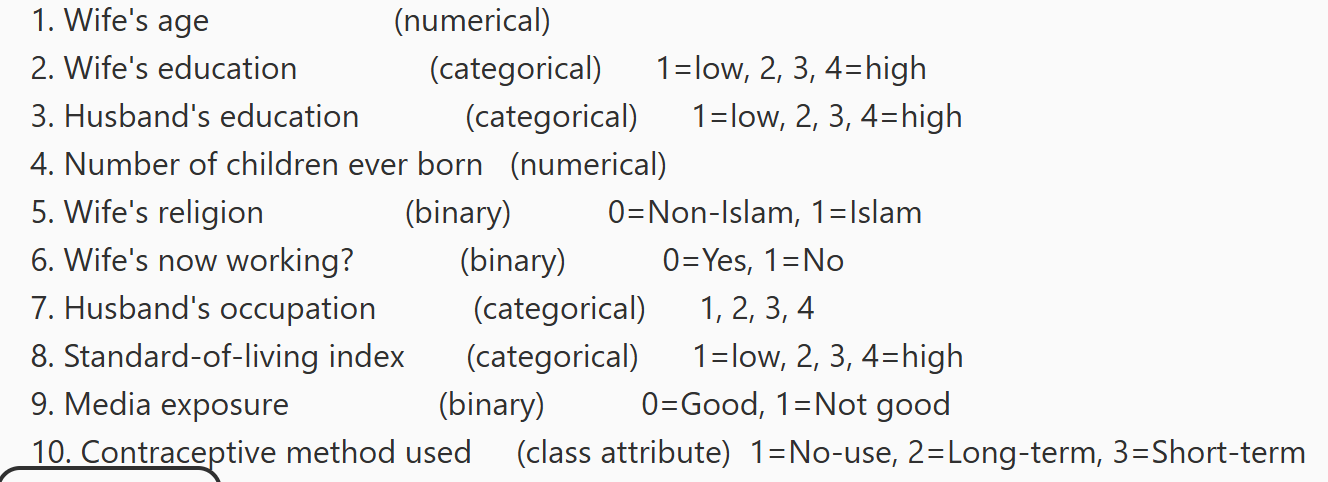

In [66]:
# Perform Cleaning
transformed_df = df.copy()

transformed_df['adjusted_method'] = np.where(df['contraceptive_method'].eq(2), 5, df['contraceptive_method'])

# Reverse so that 1/true/positive are aligned
transformed_df['wife_working'] = df['wife_working'].eq(0).astype(int)
transformed_df['media_exposure'] = df['media_exposure'].eq(0).astype(int)

transformed_df = transformed_df.drop(columns='contraceptive_method')

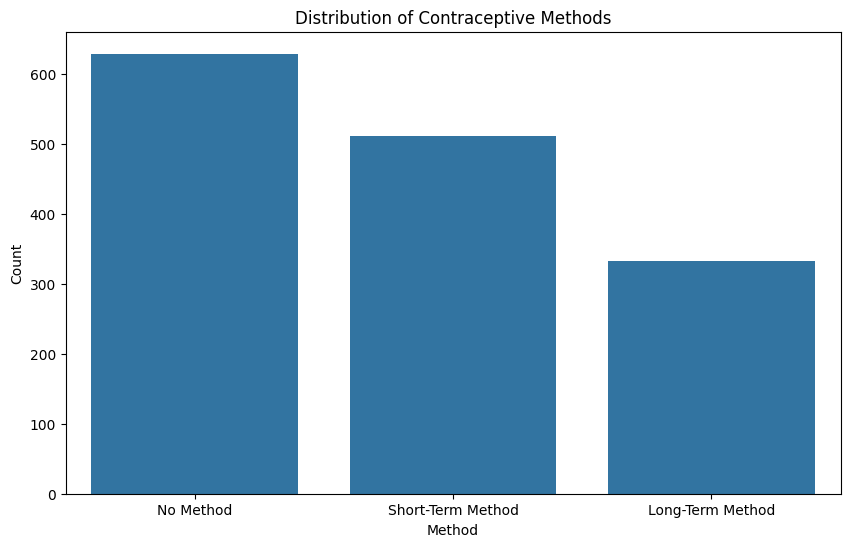

In [67]:
contra_methods = ['No Method', 'Short-Term Method', 'Long-Term Method']

method_labels = pd.DataFrame(np.select(
    [df['contraceptive_method'].eq(3), df['contraceptive_method'].eq(2)],
    contra_methods[1:],
    default=contra_methods[0]
), columns = ['Contraception Method'])

plt.figure(figsize=(10, 6))
sns.countplot(x='Contraception Method', data=method_labels, order=contra_methods)
plt.title('Distribution of Contraceptive Methods')
plt.xlabel('Method')
plt.ylabel('Count')
plt.savefig(os.path.join(plots_dir, 'class_distribution.png'))
plt.show()

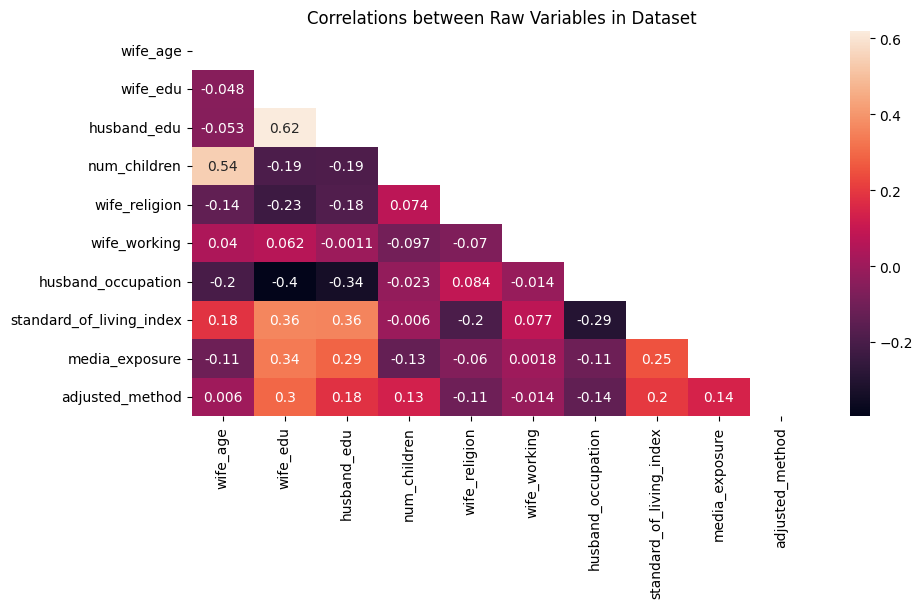

In [68]:
plt.figure(figsize=(10, 5))
plt.title('Correlations between Raw Variables in Dataset')

corr_df = transformed_df.corr()
# Create a mask of only the upper triangle, to simplify the heatmap
matrix = np.triu(corr_df)
sns.heatmap(corr_df, annot=True, mask=matrix)
plt.savefig(os.path.join(plots_dir, 'heat_map.png'), bbox_inches = 'tight')

In [69]:
# transformed_df = transformed_df.drop(columns=['wife_age', 'wife_working'])

In [88]:
# f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True, figsize=(10, 6))

# plt.suptitle('Violin Plots of 3 Variables Most Correlated with Adjusted Contraceptive Method')
# f.tight_layout()

# sns.violinplot(x="wife_edu",  y="adjusted_method", data=transformed_df, ax=ax1)
# ax1.set_xlabel("Wife's Education")

# sns.violinplot(x="standard_of_living_index",  y="adjusted_method", data=transformed_df, ax=ax2)
# ax2.set_xlabel('Standard of Living Index')

# sns.violinplot(x="husband_edu",  y="adjusted_method", data=transformed_df, ax=ax3)
# ax3.set_xlabel("Husband's Education")
# ax1.set_ylabel('Adjusted Contraceptive Method')

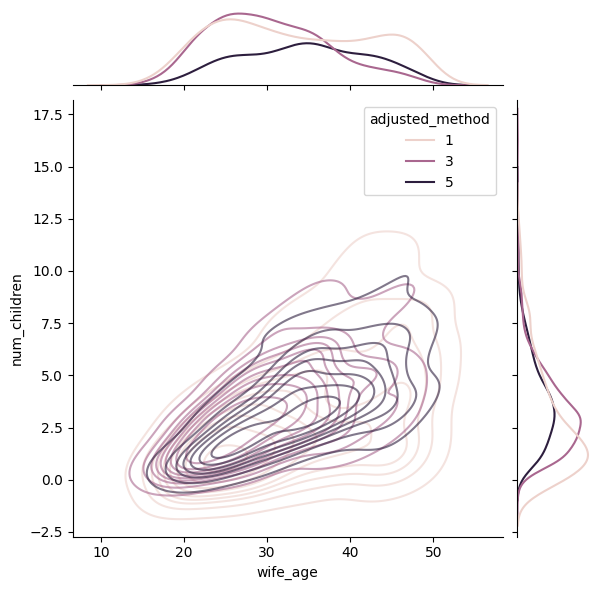

In [87]:
sns.jointplot(data=transformed_df, x="wife_age", y="num_children", hue="adjusted_method", kind="kde", alpha=0.6)

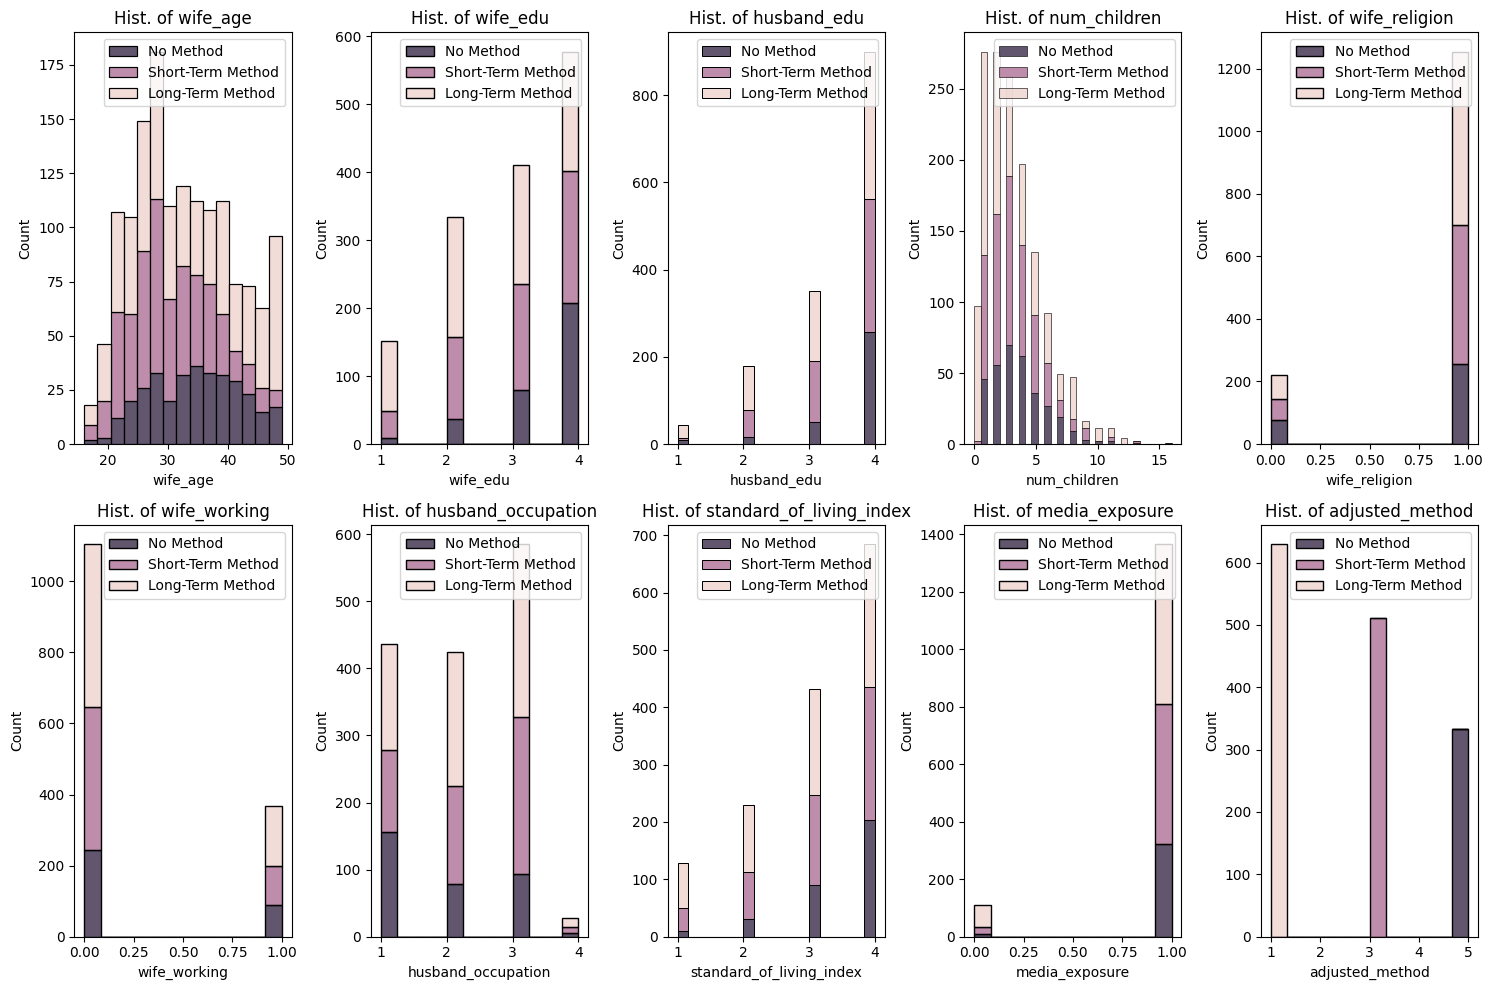

In [86]:
plt.figure(figsize=(15, 10))
for ii, feature in enumerate(transformed_df.columns, start=1):
    plt.subplot(2, 5, ii)
    sns.histplot(data=transformed_df, x=feature, hue='adjusted_method', multiple='stack')
    plt.title(f'Hist. of {feature}')
    plt.legend(title='', loc='upper right', labels=contra_methods)
    
plt.tight_layout()
plt.savefig(os.path.join(plots_dir, 'feature_distributions.png'))
plt.show()